# Выполнили: Бадмаев Валерий, Борлаков Ислам, Клотченко Сергей
# Группа э305

In [1]:
import pandas as pd
import numpy as np

Sources: 

    Real Gross Domestic Product for Canada: https://fred.stlouisfed.org/series/NGDPRSAXDCCAQ
    Global price of Brent Crude: https://fred.stlouisfed.org/series/POILBREUSDQ

Загружаем файлы из источников, открываем csv-файлы, создаем два датафрейма

In [2]:
gdp_df = pd.read_csv('NGDPRSAXDCCAQ.csv')
oilprice_df = pd.read_csv('POILBREUSDQ.csv')

Переведем данные в тип Time Series, занесем столбец вместо индекса

In [3]:
gdp_df['DATE'] = pd.to_datetime(gdp_df['DATE'])
gdp_df.set_index('DATE', inplace=True)

oilprice_df['DATE'] = pd.to_datetime(oilprice_df['DATE'])
oilprice_df.set_index('DATE', inplace=True)

### Plots

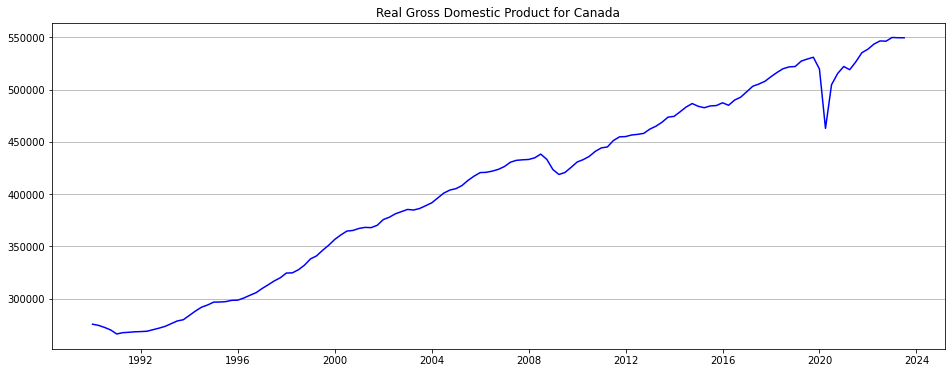

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(gdp_df.index, gdp_df['NGDPRSAXDCCAQ'], linestyle='-', color='b')
plt.title('Real Gross Domestic Product for Canada')
plt.grid(True, axis='y')

plt.show()

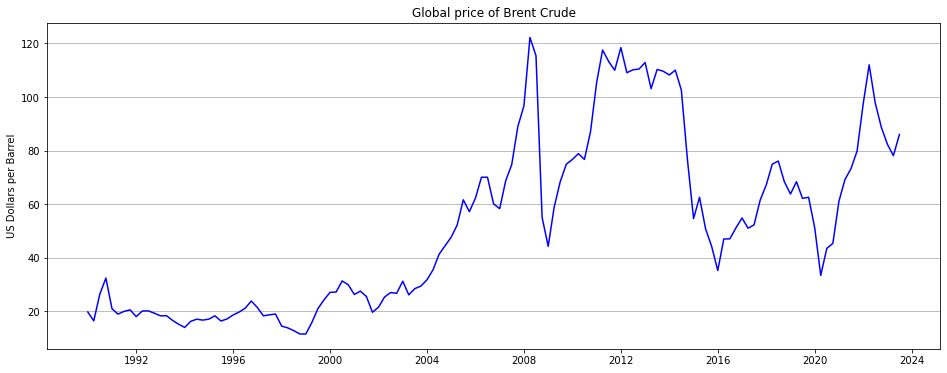

In [5]:
plt.figure(figsize=(16, 6))
plt.plot(oilprice_df.index, oilprice_df['POILBREUSDQ'], linestyle='-', color='b')
plt.title('Global price of Brent Crude')
plt.ylabel('US Dollars per Barrel')
plt.grid(True, axis='y')

plt.show()

# Переход к первым разностям, графики первых разностей

In [7]:
gdp_df['First Difference'] = gdp_df['NGDPRSAXDCCAQ'].diff() # первые разности для ВВП
oilprice_df['First Difference'] = oilprice_df['POILBREUSDQ'].diff() # первые разности для цен на нефть

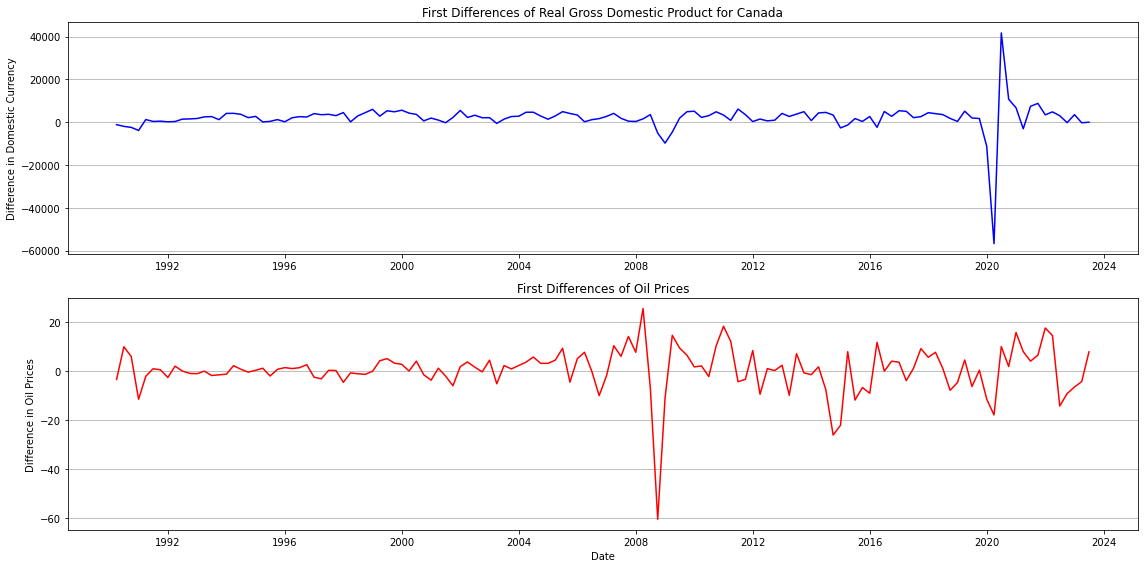

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

# График первых разностей для ВВП
gdp_df['First Difference'] = gdp_df['NGDPRSAXDCCAQ'].diff()
axes[0].plot(gdp_df.index, gdp_df['First Difference'], linestyle='-', color='b')
axes[0].set_title('First Differences of Real Gross Domestic Product for Canada')
axes[0].set_ylabel('Difference in Domestic Currency')
axes[0].grid(True, axis='y')

# График первых разностей для цен на нефть
oilprice_df['First Difference'] = oilprice_df['POILBREUSDQ'].diff()
axes[1].plot(oilprice_df.index, oilprice_df['First Difference'], linestyle='-', color='r')
axes[1].set_title('First Differences of Oil Prices')
axes[1].set_ylabel('Difference in Oil Prices')
axes[1].grid(True, axis='y')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

Судя по первым разностям для значений ВВП и цены нефти марки Brent, можно предположить, что оба ряда являются стационарными и колеблются возле нуля

Проведем два теста Дики-Фуллера для этих временных рядов

In [10]:
from statsmodels.tsa.stattools import adfuller, kpss
# Augmented DF-test
result_gdp = adfuller(gdp_df['First Difference'].dropna())
result_price = adfuller(oilprice_df['First Difference'].dropna())
# kpss test
kpss_result_gdp = kpss(gdp_df['First Difference'].dropna())
kpss_result_price = kpss(oilprice_df['First Difference'].dropna())

<ipython-input-10-05496af8dcc2>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_gdp = kpss(gdp_df['First Difference'].dropna())
<ipython-input-10-05496af8dcc2>:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_price = kpss(oilprice_df['First Difference'].dropna())


In [11]:
print('ΔGDP, p-value:', result_gdp[1])
print('ΔPrice, p-value:', result_price[1])

ΔGDP, p-value: 1.812227435848544e-13
ΔPrice, p-value: 6.6693801170525296e-15


In [12]:
print('ΔGDP, kpss test statistic:', kpss_result_gdp[0])
print('ΔPrice, kpss test statistic:', kpss_result_price[0])

ΔGDP, kpss test statistic: 0.05787929575184834
ΔPrice, kpss test statistic: 0.039114199098534266


DF тест для обоих рядов дал p-value, близкие к нулю, вследствие чего мы отвергаем нулевую гипотезу в пользу альтернативной, то есть о том, что оба ряда стационарны.

Значения расчетных статистик KPSS теста не превосходят критическое значение в 0,463, а это значит, что нулевая гипотеза не отвергается.

##### Оба ряда оказались стационарными.

Проведем еще одно преобразование данных для дальнейшего проведения теста Грейнджера

Воспользуемся функцией dropna() для избавления от NaN в первой строке, возникшему из-за расчета первых разностей

In [13]:
data_gdp = pd.DataFrame(gdp_df.rename(columns={'First Difference': 'del_GDP'})[['del_GDP']].dropna())
data_oil = pd.DataFrame(oilprice_df.rename(columns={'First Difference': 'del_OIL'})[['del_OIL']].dropna())

Объединяем в одну таблицу

In [14]:
data = pd.concat([data_gdp, data_oil], axis=1)

In [15]:
data

,del_GDP,del_OIL
DATE,,
1990-04-01,-1140.8,-3.335743
1990-07-01,-1941.0,9.973642
1990-10-01,-2427.5,6.009682
1991-01-01,-3852.5,-11.420365
1991-04-01,1240.8,-2.036887
...,...,...
2022-07-01,3035.5,-14.152665
2022-10-01,-203.5,-9.114564
2023-01-01,3538.5,-6.396517


# Granger causality test

Теперь воспользуемся библиотекой statsmodels для проведения теста Грейнджера

In [16]:
from statsmodels.tsa.stattools import grangercausalitytests

max_lag = 3  # максимальная лаговая длина
test_result = grangercausalitytests(data, max_lag, verbose=True)
# data: The data for testing whether the time series in the second column Granger causes the time series in the first column.
# Вывод результатов
for lag in range(1, max_lag + 1):
    p_value = test_result[lag][0]['ssr_ftest'][1]
    print(f'Lag {lag}: p-value = {p_value}')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8143  , p=0.0101  , df_denom=130, df_num=1
ssr based chi2 test:   chi2=6.9716  , p=0.0083  , df=1
likelihood ratio test: chi2=6.7950  , p=0.0091  , df=1
parameter F test:         F=6.8143  , p=0.0101  , df_denom=130, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6402  , p=0.0290  , df_denom=127, df_num=2
ssr based chi2 test:   chi2=7.5671  , p=0.0227  , df=2
likelihood ratio test: chi2=7.3582  , p=0.0252  , df=2
parameter F test:         F=3.6402  , p=0.0290  , df_denom=127, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.4038  , p=0.0056  , df_denom=124, df_num=3
ssr based chi2 test:   chi2=13.9573 , p=0.0030  , df=3
likelihood ratio test: chi2=13.2627 , p=0.0041  , df=3
parameter F test:         F=4.4038  , p=0.0056  , df_denom=124, df_num=3
Lag 1: p-value = 0.010104564924610667
Lag 2: p-value = 0.029021183504436356
Lag 3: p-value = 0

c:\users\vbadmaev1\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Для трех значений лагов в тесте Грейнжера p-value меньше 0,05, поэтому во всех трех случаях нулевая гипотеза отклоняется.

Нулевая гипотеза: изменение цены на нефть не влияет на изменение ВВП, во всех трех тестах мы её **отклоняем**

Далее оценим влияние изменения ВВП на изменение цены на нефть

In [17]:
max_lag = 3  # Предполагаемый максимальный лаг для теста
test_result = grangercausalitytests(data[['del_OIL', 'del_GDP']], max_lag, verbose=True)
# здесь уже оцениваем влияние 'del_GDP' на 'del_OIL'
# Выведем результаты
for lag in range(1, max_lag + 1):
    p_value = test_result[lag][0]['ssr_ftest'][1]
    print(f'Lag {lag}: p-value = {p_value}')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4311  , p=0.2338  , df_denom=130, df_num=1
ssr based chi2 test:   chi2=1.4641  , p=0.2263  , df=1
likelihood ratio test: chi2=1.4561  , p=0.2275  , df=1
parameter F test:         F=1.4311  , p=0.2338  , df_denom=130, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0668  , p=0.1308  , df_denom=127, df_num=2
ssr based chi2 test:   chi2=4.2964  , p=0.1167  , df=2
likelihood ratio test: chi2=4.2279  , p=0.1208  , df=2
parameter F test:         F=2.0668  , p=0.1308  , df_denom=127, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9419  , p=0.1263  , df_denom=124, df_num=3
ssr based chi2 test:   chi2=6.1546  , p=0.1043  , df=3
likelihood ratio test: chi2=6.0144  , p=0.1109  , df=3
parameter F test:         F=1.9419  , p=0.1263  , df_denom=124, df_num=3
Lag 1: p-value = 0.23375967721095386
Lag 2: p-value = 0.13082597680934085
Lag 3: p-value = 0.1

c:\users\vbadmaev1\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Полученные p-значения больше допустимых уровней значимости, значит нулевая гипотеза принимается во всех трёх тестах.

Соответственно, переменная __изменения цены на нефть__ является `причиной по Грейнжеру` для **изменения ВВП**

# ARDL Modeling

Мы получили те результаты, которые и ожидали от теста Грейнджера, строим ARDL модель, где изменение ВВП - зависимая переменная

In [19]:
from statsmodels.tsa.ardl import ardl_select_order

sel_res = ardl_select_order(
    data.del_GDP, 5, data[["del_OIL"]], 5, ic="aic", trend="c"
)
print(f"The optimal order is: {sel_res.model.ardl_order}")

The optimal order is: (3, 3)


c:\users\vbadmaev1\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\users\vbadmaev1\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [20]:
sel_res

In [33]:
res = sel_res.model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                del_GDP   No. Observations:                  134
Model:                     ARDL(3, 3)   Log Likelihood               -1326.900
Method:               Conditional MLE   S.D. of innovations           6063.648
Date:                Sun, 24 Dec 2023   AIC                           2671.799
Time:                        22:33:30   BIC                           2697.676
Sample:                    01-01-1991   HQIC                          2682.314
                         - 07-01-2023                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3385.6981    654.734      5.171      0.000    2089.692    4681.704
del_GDP.L1    -0.2694      0.088     -3.067      0.003      -0.443      -0.096
del_GDP.L2    -0.2553      0.088     -2.894      0.005      -0.430      -0.081
del_GDP.L3    -0.1893      0.089     -2.130      0.035      -0.365      -0.013
del_OIL.L0   211.4262     65.793      3.213      0.002      81.193     341.660
del_OIL.L1   150.3270     72.929      2.061      0.041       5.969     294.685
del_OIL.L2    67.7923     71.878      0.943      0.347     -74.485     210.070
del_OIL.L3   131.6585     69.671      1.890      0.061      -6.252     269.569
==============================================================================
"""

Эта модель была подобрана функцией `ardl_select_order`, который предложил нам использовать по три лага, но, исходя из логических соображений, мы выбрали модель с четырьмя лагами, так как данные представлены поквартально

In [34]:
from statsmodels.tsa.api import ARDL

ardl_model = ARDL(
    data.del_GDP,
    4,
    data[["del_OIL"]],
    {"del_OIL": 4},
    trend="c",
    causal=False,
).fit()
ardl_model.summary()

c:\users\vbadmaev1\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                del_GDP   No. Observations:                  134
Model:                     ARDL(4, 4)   Log Likelihood               -1316.127
Method:               Conditional MLE   S.D. of innovations           6033.702
Date:                Sun, 24 Dec 2023   AIC                           2654.254
Time:                        22:34:00   BIC                           2685.797
Sample:                    04-01-1991   HQIC                          2667.071
                         - 07-01-2023                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3372.7246    728.164      4.632      0.000    1931.010    4814.439
del_GDP.L1    -0.2689      0.091     -2.961      0.004      -0.449      -0.089
del_GDP.L2    -0.2492      0.092     -2.704      0.008      -0.432      -0.067
del_GDP.L3    -0.1822      0.092     -1.977      0.050      -0.365       0.000
del_GDP.L4     0.0369      0.091      0.406      0.686      -0.143       0.217
del_OIL.L0   199.4608     66.581      2.996      0.003      67.634     331.287
del_OIL.L1   159.3999     73.579      2.166      0.032      13.720     305.080
del_OIL.L2    52.7459     77.432      0.681      0.497    -100.564     206.056
del_OIL.L3   146.2073     72.509      2.016      0.046       2.645     289.770
del_OIL.L4   -58.8453     71.273     -0.826      0.411    -199.960      82.270
==============================================================================
"""

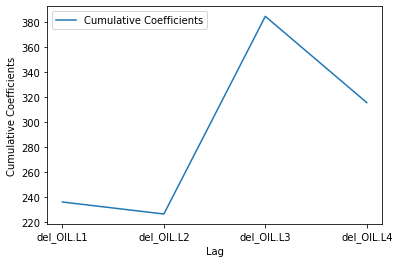

In [32]:
cum = np.cumsum(ardl_model.params[5:])
plt.plot(cum, label="Cumulative Coefficients")
plt.xlabel("Lag")
plt.ylabel("Cumulative Coefficients")
plt.legend()
plt.show()

Мгновенный эффект: 199.46

Долгосрочный динамический мультипликатор: 299.96

Мгновенный эффект оказался меньше долгосрочного динамического мультипликатора, что и соответствует нашим ожиданиям. Размерность данных - доллары США (цены взяты на начало 1990-го года)

# Выводы:

Было выявлено, что именно изменение цен на нефть влияет на изменение реального ВВП Канады (страны-экспортера нефти), а не наоборот. 

На стационарных первых разностях была построена модель ARDL, которая хорошо описывает изменение ВВП Канады (на квартальных данных).

Были найдены величины мгновенного эффекта и долгосрочного динамического мультипликатора, которые составили 199,46 и 299,96 соответственно.